In [1]:
import os
import pickle

import numpy as np
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F
import librosa
import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim

        self.conv_layers = nn.ModuleList()
        in_channels = input_shape[0]
        for i in range(len(conv_filters)):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, conv_filters[i], conv_kernels[i], conv_strides[i], padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(conv_filters[i])
                )
            )
            in_channels = conv_filters[i]

        self.flatten = nn.Flatten()
        self.shape_before_bottleneck = self._calculate_shape_before_bottleneck()
        self.mu = nn.Linear(np.prod(self.shape_before_bottleneck), latent_space_dim)
        self.log_variance = nn.Linear(np.prod(self.shape_before_bottleneck), latent_space_dim)

    def _calculate_shape_before_bottleneck(self):
        sample_data = torch.rand(1, *self.input_shape)
        for layer in self.conv_layers:
            sample_data = layer(sample_data)
        return sample_data.shape[1:]

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        self._shape_before_bottleneck = x.shape[1:]
        x = self.flatten(x)
        mu = self.mu(x)
        log_variance = self.log_variance(x)
        return mu, log_variance

class Decoder(nn.Module):
    def __init__(self, shape_before_bottleneck, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(Decoder, self).__init__()
        self.shape_before_bottleneck = shape_before_bottleneck
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim

        self.dense = nn.Linear(latent_space_dim, np.prod(shape_before_bottleneck))
        self.reshape = shape_before_bottleneck

        self.conv_transpose_layers = nn.ModuleList()
        in_channels = conv_filters[-1]
        for i in range(len(conv_filters) - 1, 0, -1):
            stride = conv_strides[i]
            output_padding = 1 if (isinstance(stride, int) and stride > 1) or (isinstance(stride, tuple) and max(stride) > 1) else 0
            self.conv_transpose_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels, conv_filters[i-1], conv_kernels[i], stride, padding=1, output_padding=output_padding),
                    nn.ReLU(),
                    nn.BatchNorm2d(conv_filters[i-1])
                )
            )
            in_channels = conv_filters[i-1]

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(conv_filters[0], 1, conv_kernels[0], conv_strides[0], padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, *self.reshape)
        for layer in self.conv_transpose_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

class VAE(nn.Module):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim
        self.reconstruction_loss_weight = 1000

        self.encoder = Encoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim)
        shape_before_bottleneck = self.encoder.shape_before_bottleneck
        self.decoder = Decoder(shape_before_bottleneck, conv_filters, conv_kernels, conv_strides, latent_space_dim)

    def forward(self, x):
        mu, log_variance = self.encoder(x)
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        z = mu + eps * std
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_variance

    def calculate_loss(self, x, reconstructed, mu, log_variance):
        reconstruction_loss = F.mse_loss(reconstructed, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_variance - mu.pow(2) - log_variance.exp())
        return reconstruction_loss * self.reconstruction_loss_weight + kl_loss

    def summary(self):
        print("Encoder Summary:\n")
        print(self.encoder)
        print("\nDecoder Summary:\n")
        print(self.decoder)

    def compile(self, learning_rate=0.0001):
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def train_model(self, x_train, batch_size, num_epochs):
        data_loader = DataLoader(TensorDataset(x_train, x_train), batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs):
            for data in data_loader:
                x = data[0]
                reconstructed, mu, log_variance = self(x)
                loss = self.calculate_loss(x, reconstructed, mu, log_variance)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.load_state_dict(torch.load(weights_path))

    def reconstruct(self, images):
        with torch.no_grad():
            mu, log_variance = self.encoder(images)
            std = torch.exp(0.5 * log_variance)
            eps = torch.randn_like(std)
            z = mu + eps * std
            reconstructed = self.decoder(z)
        return reconstructed, mu

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.pth")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.pth")
        torch.save(self.state_dict(), save_path)

In [3]:
def load_mnist():
    from torchvision import datasets, transforms

    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    x_train = mnist_train.data.unsqueeze(1).float() / 255.0
    y_train = mnist_train.targets
    x_test = mnist_test.data.unsqueeze(1).float() / 255.0
    y_test = mnist_test.targets

    return x_train, y_train, x_test, y_test

def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(10, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

def select_images(images, labels, num_images=8):
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index]
    sample_labels = labels[sample_images_index]
    return sample_images, sample_labels

In [33]:
if __name__ == "__main__":
    LEARNING_RATE = 0.0005
    BATCH_SIZE = 64
    EPOCHS = 20

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    x_train = mnist_data.data.unsqueeze(1).float().clone().detach() / 255.0

    autoencoder = VAE(
        input_shape=(1, 28, 28),
        conv_filters=[32, 64, 64, 64],
        conv_kernels=[3, 3, 3, 3],
        conv_strides=[1, 2, 2, 1],
        latent_space_dim=10
    )

    autoencoder.summary()
    autoencoder.compile(learning_rate=LEARNING_RATE)

    autoencoder.train_model(x_train, batch_size=BATCH_SIZE, num_epochs=EPOCHS)
    autoencoder.save("model")

Encoder Summary:

Encoder(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=3136, out_featur

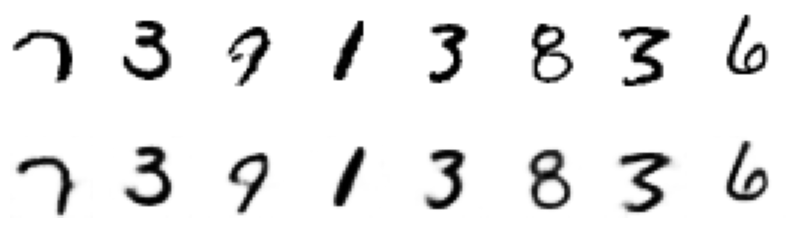

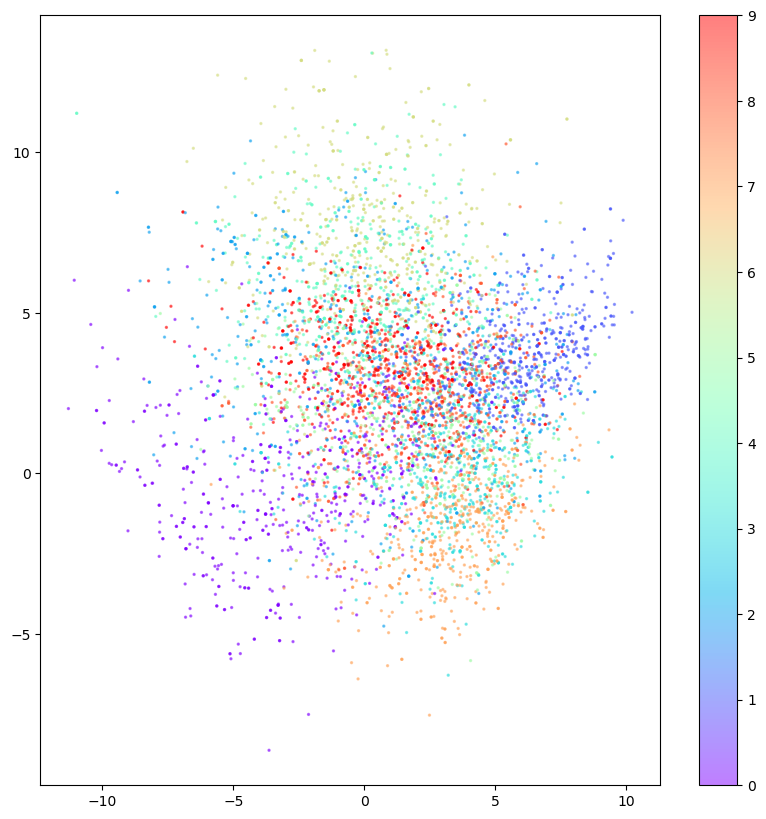

In [34]:
if __name__ == "__main__":
    autoencoder = VAE.load("model")
    x_train, y_train, x_test, y_test = load_mnist()

    num_sample_images_to_show = 8
    sample_images, _ = select_images(x_test, y_test, num_sample_images_to_show)
    reconstructed_images, _ = autoencoder.reconstruct(sample_images)
    plot_reconstructed_images(sample_images, reconstructed_images)

    num_images = 6000
    sample_images, sample_labels = select_images(x_test, y_test, num_images)
    _, latent_representations = autoencoder.reconstruct(sample_images)
    plot_images_encoded_in_latent_space(latent_representations, sample_labels)

In [6]:
class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal


class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram


class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)
        return save_path

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path


class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }

if __name__ == "__main__":
    FRAME_SIZE = 512
    HOP_LENGTH = 256
    DURATION = 0.74  # in seconds
    SAMPLE_RATE = 22050
    MONO = True

    SPECTROGRAMS_SAVE_DIR = "./MusicGeneration/spectogram_save_dir"
    MIN_MAX_VALUES_SAVE_DIR = "./MusicGeneration/MinMax_dir"
    FILES_DIR = "./MusicGeneration/recordings"

    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION, MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

Processed file ./MusicGeneration/recordings\0_george_0.wav
Processed file ./MusicGeneration/recordings\0_george_1.wav
Processed file ./MusicGeneration/recordings\0_george_10.wav
Processed file ./MusicGeneration/recordings\0_george_11.wav
Processed file ./MusicGeneration/recordings\0_george_12.wav
Processed file ./MusicGeneration/recordings\0_george_13.wav
Processed file ./MusicGeneration/recordings\0_george_14.wav
Processed file ./MusicGeneration/recordings\0_george_15.wav
Processed file ./MusicGeneration/recordings\0_george_16.wav
Processed file ./MusicGeneration/recordings\0_george_17.wav
Processed file ./MusicGeneration/recordings\0_george_18.wav
Processed file ./MusicGeneration/recordings\0_george_19.wav
Processed file ./MusicGeneration/recordings\0_george_2.wav
Processed file ./MusicGeneration/recordings\0_george_20.wav
Processed file ./MusicGeneration/recordings\0_george_21.wav
Processed file ./MusicGeneration/recordings\0_george_22.wav
Processed file ./MusicGeneration/recordings

Processed file ./MusicGeneration/recordings\0_lucas_49.wav
Processed file ./MusicGeneration/recordings\0_lucas_5.wav
Processed file ./MusicGeneration/recordings\0_lucas_6.wav
Processed file ./MusicGeneration/recordings\0_lucas_7.wav
Processed file ./MusicGeneration/recordings\0_lucas_8.wav
Processed file ./MusicGeneration/recordings\0_lucas_9.wav
Processed file ./MusicGeneration/recordings\0_nicolas_0.wav
Processed file ./MusicGeneration/recordings\0_nicolas_1.wav
Processed file ./MusicGeneration/recordings\0_nicolas_10.wav
Processed file ./MusicGeneration/recordings\0_nicolas_11.wav
Processed file ./MusicGeneration/recordings\0_nicolas_12.wav
Processed file ./MusicGeneration/recordings\0_nicolas_13.wav
Processed file ./MusicGeneration/recordings\0_nicolas_14.wav
Processed file ./MusicGeneration/recordings\0_nicolas_15.wav
Processed file ./MusicGeneration/recordings\0_nicolas_16.wav
Processed file ./MusicGeneration/recordings\0_nicolas_17.wav
Processed file ./MusicGeneration/recordings

Processed file ./MusicGeneration/recordings\0_yweweler_6.wav
Processed file ./MusicGeneration/recordings\0_yweweler_7.wav
Processed file ./MusicGeneration/recordings\0_yweweler_8.wav
Processed file ./MusicGeneration/recordings\0_yweweler_9.wav
Processed file ./MusicGeneration/recordings\1_george_0.wav
Processed file ./MusicGeneration/recordings\1_george_1.wav
Processed file ./MusicGeneration/recordings\1_george_10.wav
Processed file ./MusicGeneration/recordings\1_george_11.wav
Processed file ./MusicGeneration/recordings\1_george_12.wav
Processed file ./MusicGeneration/recordings\1_george_13.wav
Processed file ./MusicGeneration/recordings\1_george_14.wav
Processed file ./MusicGeneration/recordings\1_george_15.wav
Processed file ./MusicGeneration/recordings\1_george_16.wav
Processed file ./MusicGeneration/recordings\1_george_17.wav
Processed file ./MusicGeneration/recordings\1_george_18.wav
Processed file ./MusicGeneration/recordings\1_george_19.wav
Processed file ./MusicGeneration/recor

Processed file ./MusicGeneration/recordings\1_lucas_42.wav
Processed file ./MusicGeneration/recordings\1_lucas_43.wav
Processed file ./MusicGeneration/recordings\1_lucas_44.wav
Processed file ./MusicGeneration/recordings\1_lucas_45.wav
Processed file ./MusicGeneration/recordings\1_lucas_46.wav
Processed file ./MusicGeneration/recordings\1_lucas_47.wav
Processed file ./MusicGeneration/recordings\1_lucas_48.wav
Processed file ./MusicGeneration/recordings\1_lucas_49.wav
Processed file ./MusicGeneration/recordings\1_lucas_5.wav
Processed file ./MusicGeneration/recordings\1_lucas_6.wav
Processed file ./MusicGeneration/recordings\1_lucas_7.wav
Processed file ./MusicGeneration/recordings\1_lucas_8.wav
Processed file ./MusicGeneration/recordings\1_lucas_9.wav
Processed file ./MusicGeneration/recordings\1_nicolas_0.wav
Processed file ./MusicGeneration/recordings\1_nicolas_1.wav
Processed file ./MusicGeneration/recordings\1_nicolas_10.wav
Processed file ./MusicGeneration/recordings\1_nicolas_11.

Processed file ./MusicGeneration/recordings\1_yweweler_42.wav
Processed file ./MusicGeneration/recordings\1_yweweler_43.wav
Processed file ./MusicGeneration/recordings\1_yweweler_44.wav
Processed file ./MusicGeneration/recordings\1_yweweler_45.wav
Processed file ./MusicGeneration/recordings\1_yweweler_46.wav
Processed file ./MusicGeneration/recordings\1_yweweler_47.wav
Processed file ./MusicGeneration/recordings\1_yweweler_48.wav
Processed file ./MusicGeneration/recordings\1_yweweler_49.wav
Processed file ./MusicGeneration/recordings\1_yweweler_5.wav
Processed file ./MusicGeneration/recordings\1_yweweler_6.wav
Processed file ./MusicGeneration/recordings\1_yweweler_7.wav
Processed file ./MusicGeneration/recordings\1_yweweler_8.wav
Processed file ./MusicGeneration/recordings\1_yweweler_9.wav
Processed file ./MusicGeneration/recordings\2_george_0.wav
Processed file ./MusicGeneration/recordings\2_george_1.wav
Processed file ./MusicGeneration/recordings\2_george_10.wav
Processed file ./Musi

Processed file ./MusicGeneration/recordings\2_lucas_36.wav
Processed file ./MusicGeneration/recordings\2_lucas_37.wav
Processed file ./MusicGeneration/recordings\2_lucas_38.wav
Processed file ./MusicGeneration/recordings\2_lucas_39.wav
Processed file ./MusicGeneration/recordings\2_lucas_4.wav
Processed file ./MusicGeneration/recordings\2_lucas_40.wav
Processed file ./MusicGeneration/recordings\2_lucas_41.wav
Processed file ./MusicGeneration/recordings\2_lucas_42.wav
Processed file ./MusicGeneration/recordings\2_lucas_43.wav
Processed file ./MusicGeneration/recordings\2_lucas_44.wav
Processed file ./MusicGeneration/recordings\2_lucas_45.wav
Processed file ./MusicGeneration/recordings\2_lucas_46.wav
Processed file ./MusicGeneration/recordings\2_lucas_47.wav
Processed file ./MusicGeneration/recordings\2_lucas_48.wav
Processed file ./MusicGeneration/recordings\2_lucas_49.wav
Processed file ./MusicGeneration/recordings\2_lucas_5.wav
Processed file ./MusicGeneration/recordings\2_lucas_6.wav


Processed file ./MusicGeneration/recordings\2_yweweler_44.wav
Processed file ./MusicGeneration/recordings\2_yweweler_45.wav
Processed file ./MusicGeneration/recordings\2_yweweler_46.wav
Processed file ./MusicGeneration/recordings\2_yweweler_47.wav
Processed file ./MusicGeneration/recordings\2_yweweler_48.wav
Processed file ./MusicGeneration/recordings\2_yweweler_49.wav
Processed file ./MusicGeneration/recordings\2_yweweler_5.wav
Processed file ./MusicGeneration/recordings\2_yweweler_6.wav
Processed file ./MusicGeneration/recordings\2_yweweler_7.wav
Processed file ./MusicGeneration/recordings\2_yweweler_8.wav
Processed file ./MusicGeneration/recordings\2_yweweler_9.wav
Processed file ./MusicGeneration/recordings\3_george_0.wav
Processed file ./MusicGeneration/recordings\3_george_1.wav
Processed file ./MusicGeneration/recordings\3_george_10.wav
Processed file ./MusicGeneration/recordings\3_george_11.wav
Processed file ./MusicGeneration/recordings\3_george_12.wav
Processed file ./MusicGen

Processed file ./MusicGeneration/recordings\3_lucas_42.wav
Processed file ./MusicGeneration/recordings\3_lucas_43.wav
Processed file ./MusicGeneration/recordings\3_lucas_44.wav
Processed file ./MusicGeneration/recordings\3_lucas_45.wav
Processed file ./MusicGeneration/recordings\3_lucas_46.wav
Processed file ./MusicGeneration/recordings\3_lucas_47.wav
Processed file ./MusicGeneration/recordings\3_lucas_48.wav
Processed file ./MusicGeneration/recordings\3_lucas_49.wav
Processed file ./MusicGeneration/recordings\3_lucas_5.wav
Processed file ./MusicGeneration/recordings\3_lucas_6.wav
Processed file ./MusicGeneration/recordings\3_lucas_7.wav
Processed file ./MusicGeneration/recordings\3_lucas_8.wav
Processed file ./MusicGeneration/recordings\3_lucas_9.wav
Processed file ./MusicGeneration/recordings\3_nicolas_0.wav
Processed file ./MusicGeneration/recordings\3_nicolas_1.wav
Processed file ./MusicGeneration/recordings\3_nicolas_10.wav
Processed file ./MusicGeneration/recordings\3_nicolas_11.

Processed file ./MusicGeneration/recordings\4_george_0.wav
Processed file ./MusicGeneration/recordings\4_george_1.wav
Processed file ./MusicGeneration/recordings\4_george_10.wav
Processed file ./MusicGeneration/recordings\4_george_11.wav
Processed file ./MusicGeneration/recordings\4_george_12.wav
Processed file ./MusicGeneration/recordings\4_george_13.wav
Processed file ./MusicGeneration/recordings\4_george_14.wav
Processed file ./MusicGeneration/recordings\4_george_15.wav
Processed file ./MusicGeneration/recordings\4_george_16.wav
Processed file ./MusicGeneration/recordings\4_george_17.wav
Processed file ./MusicGeneration/recordings\4_george_18.wav
Processed file ./MusicGeneration/recordings\4_george_19.wav
Processed file ./MusicGeneration/recordings\4_george_2.wav
Processed file ./MusicGeneration/recordings\4_george_20.wav
Processed file ./MusicGeneration/recordings\4_george_21.wav
Processed file ./MusicGeneration/recordings\4_george_22.wav
Processed file ./MusicGeneration/recordings

Processed file ./MusicGeneration/recordings\4_nicolas_34.wav
Processed file ./MusicGeneration/recordings\4_nicolas_35.wav
Processed file ./MusicGeneration/recordings\4_nicolas_36.wav
Processed file ./MusicGeneration/recordings\4_nicolas_37.wav
Processed file ./MusicGeneration/recordings\4_nicolas_38.wav
Processed file ./MusicGeneration/recordings\4_nicolas_39.wav
Processed file ./MusicGeneration/recordings\4_nicolas_4.wav
Processed file ./MusicGeneration/recordings\4_nicolas_40.wav
Processed file ./MusicGeneration/recordings\4_nicolas_41.wav
Processed file ./MusicGeneration/recordings\4_nicolas_42.wav
Processed file ./MusicGeneration/recordings\4_nicolas_43.wav
Processed file ./MusicGeneration/recordings\4_nicolas_44.wav
Processed file ./MusicGeneration/recordings\4_nicolas_45.wav
Processed file ./MusicGeneration/recordings\4_nicolas_46.wav
Processed file ./MusicGeneration/recordings\4_nicolas_47.wav
Processed file ./MusicGeneration/recordings\4_nicolas_48.wav
Processed file ./MusicGen

Processed file ./MusicGeneration/recordings\5_george_46.wav
Processed file ./MusicGeneration/recordings\5_george_47.wav
Processed file ./MusicGeneration/recordings\5_george_48.wav
Processed file ./MusicGeneration/recordings\5_george_49.wav
Processed file ./MusicGeneration/recordings\5_george_5.wav
Processed file ./MusicGeneration/recordings\5_george_6.wav
Processed file ./MusicGeneration/recordings\5_george_7.wav
Processed file ./MusicGeneration/recordings\5_george_8.wav
Processed file ./MusicGeneration/recordings\5_george_9.wav
Processed file ./MusicGeneration/recordings\5_jackson_0.wav
Processed file ./MusicGeneration/recordings\5_jackson_1.wav
Processed file ./MusicGeneration/recordings\5_jackson_10.wav
Processed file ./MusicGeneration/recordings\5_jackson_11.wav
Processed file ./MusicGeneration/recordings\5_jackson_12.wav
Processed file ./MusicGeneration/recordings\5_jackson_13.wav
Processed file ./MusicGeneration/recordings\5_jackson_14.wav
Processed file ./MusicGeneration/recordi

Processed file ./MusicGeneration/recordings\5_nicolas_39.wav
Processed file ./MusicGeneration/recordings\5_nicolas_4.wav
Processed file ./MusicGeneration/recordings\5_nicolas_40.wav
Processed file ./MusicGeneration/recordings\5_nicolas_41.wav
Processed file ./MusicGeneration/recordings\5_nicolas_42.wav
Processed file ./MusicGeneration/recordings\5_nicolas_43.wav
Processed file ./MusicGeneration/recordings\5_nicolas_44.wav
Processed file ./MusicGeneration/recordings\5_nicolas_45.wav
Processed file ./MusicGeneration/recordings\5_nicolas_46.wav
Processed file ./MusicGeneration/recordings\5_nicolas_47.wav
Processed file ./MusicGeneration/recordings\5_nicolas_48.wav
Processed file ./MusicGeneration/recordings\5_nicolas_49.wav
Processed file ./MusicGeneration/recordings\5_nicolas_5.wav
Processed file ./MusicGeneration/recordings\5_nicolas_6.wav
Processed file ./MusicGeneration/recordings\5_nicolas_7.wav
Processed file ./MusicGeneration/recordings\5_nicolas_8.wav
Processed file ./MusicGenerat

Processed file ./MusicGeneration/recordings\6_george_31.wav
Processed file ./MusicGeneration/recordings\6_george_32.wav
Processed file ./MusicGeneration/recordings\6_george_33.wav
Processed file ./MusicGeneration/recordings\6_george_34.wav
Processed file ./MusicGeneration/recordings\6_george_35.wav
Processed file ./MusicGeneration/recordings\6_george_36.wav
Processed file ./MusicGeneration/recordings\6_george_37.wav
Processed file ./MusicGeneration/recordings\6_george_38.wav
Processed file ./MusicGeneration/recordings\6_george_39.wav
Processed file ./MusicGeneration/recordings\6_george_4.wav
Processed file ./MusicGeneration/recordings\6_george_40.wav
Processed file ./MusicGeneration/recordings\6_george_41.wav
Processed file ./MusicGeneration/recordings\6_george_42.wav
Processed file ./MusicGeneration/recordings\6_george_43.wav
Processed file ./MusicGeneration/recordings\6_george_44.wav
Processed file ./MusicGeneration/recordings\6_george_45.wav
Processed file ./MusicGeneration/recordin

Processed file ./MusicGeneration/recordings\6_nicolas_40.wav
Processed file ./MusicGeneration/recordings\6_nicolas_41.wav
Processed file ./MusicGeneration/recordings\6_nicolas_42.wav
Processed file ./MusicGeneration/recordings\6_nicolas_43.wav
Processed file ./MusicGeneration/recordings\6_nicolas_44.wav
Processed file ./MusicGeneration/recordings\6_nicolas_45.wav
Processed file ./MusicGeneration/recordings\6_nicolas_46.wav
Processed file ./MusicGeneration/recordings\6_nicolas_47.wav
Processed file ./MusicGeneration/recordings\6_nicolas_48.wav
Processed file ./MusicGeneration/recordings\6_nicolas_49.wav
Processed file ./MusicGeneration/recordings\6_nicolas_5.wav
Processed file ./MusicGeneration/recordings\6_nicolas_6.wav
Processed file ./MusicGeneration/recordings\6_nicolas_7.wav
Processed file ./MusicGeneration/recordings\6_nicolas_8.wav
Processed file ./MusicGeneration/recordings\6_nicolas_9.wav
Processed file ./MusicGeneration/recordings\6_theo_0.wav
Processed file ./MusicGeneration/

Processed file ./MusicGeneration/recordings\7_jackson_17.wav
Processed file ./MusicGeneration/recordings\7_jackson_18.wav
Processed file ./MusicGeneration/recordings\7_jackson_19.wav
Processed file ./MusicGeneration/recordings\7_jackson_2.wav
Processed file ./MusicGeneration/recordings\7_jackson_20.wav
Processed file ./MusicGeneration/recordings\7_jackson_21.wav
Processed file ./MusicGeneration/recordings\7_jackson_22.wav
Processed file ./MusicGeneration/recordings\7_jackson_23.wav
Processed file ./MusicGeneration/recordings\7_jackson_24.wav
Processed file ./MusicGeneration/recordings\7_jackson_25.wav
Processed file ./MusicGeneration/recordings\7_jackson_26.wav
Processed file ./MusicGeneration/recordings\7_jackson_27.wav
Processed file ./MusicGeneration/recordings\7_jackson_28.wav
Processed file ./MusicGeneration/recordings\7_jackson_29.wav
Processed file ./MusicGeneration/recordings\7_jackson_3.wav
Processed file ./MusicGeneration/recordings\7_jackson_30.wav
Processed file ./MusicGene

Processed file ./MusicGeneration/recordings\7_theo_10.wav
Processed file ./MusicGeneration/recordings\7_theo_11.wav
Processed file ./MusicGeneration/recordings\7_theo_12.wav
Processed file ./MusicGeneration/recordings\7_theo_13.wav
Processed file ./MusicGeneration/recordings\7_theo_14.wav
Processed file ./MusicGeneration/recordings\7_theo_15.wav
Processed file ./MusicGeneration/recordings\7_theo_16.wav
Processed file ./MusicGeneration/recordings\7_theo_17.wav
Processed file ./MusicGeneration/recordings\7_theo_18.wav
Processed file ./MusicGeneration/recordings\7_theo_19.wav
Processed file ./MusicGeneration/recordings\7_theo_2.wav
Processed file ./MusicGeneration/recordings\7_theo_20.wav
Processed file ./MusicGeneration/recordings\7_theo_21.wav
Processed file ./MusicGeneration/recordings\7_theo_22.wav
Processed file ./MusicGeneration/recordings\7_theo_23.wav
Processed file ./MusicGeneration/recordings\7_theo_24.wav
Processed file ./MusicGeneration/recordings\7_theo_25.wav
Processed file 

Processed file ./MusicGeneration/recordings\8_george_44.wav
Processed file ./MusicGeneration/recordings\8_george_45.wav
Processed file ./MusicGeneration/recordings\8_george_46.wav
Processed file ./MusicGeneration/recordings\8_george_47.wav
Processed file ./MusicGeneration/recordings\8_george_48.wav
Processed file ./MusicGeneration/recordings\8_george_49.wav
Processed file ./MusicGeneration/recordings\8_george_5.wav
Processed file ./MusicGeneration/recordings\8_george_6.wav
Processed file ./MusicGeneration/recordings\8_george_7.wav
Processed file ./MusicGeneration/recordings\8_george_8.wav
Processed file ./MusicGeneration/recordings\8_george_9.wav
Processed file ./MusicGeneration/recordings\8_jackson_0.wav
Processed file ./MusicGeneration/recordings\8_jackson_1.wav
Processed file ./MusicGeneration/recordings\8_jackson_10.wav
Processed file ./MusicGeneration/recordings\8_jackson_11.wav
Processed file ./MusicGeneration/recordings\8_jackson_12.wav
Processed file ./MusicGeneration/recording

Processed file ./MusicGeneration/recordings\8_theo_23.wav
Processed file ./MusicGeneration/recordings\8_theo_24.wav
Processed file ./MusicGeneration/recordings\8_theo_25.wav
Processed file ./MusicGeneration/recordings\8_theo_26.wav
Processed file ./MusicGeneration/recordings\8_theo_27.wav
Processed file ./MusicGeneration/recordings\8_theo_28.wav
Processed file ./MusicGeneration/recordings\8_theo_29.wav
Processed file ./MusicGeneration/recordings\8_theo_3.wav
Processed file ./MusicGeneration/recordings\8_theo_30.wav
Processed file ./MusicGeneration/recordings\8_theo_31.wav
Processed file ./MusicGeneration/recordings\8_theo_32.wav
Processed file ./MusicGeneration/recordings\8_theo_33.wav
Processed file ./MusicGeneration/recordings\8_theo_34.wav
Processed file ./MusicGeneration/recordings\8_theo_35.wav
Processed file ./MusicGeneration/recordings\8_theo_36.wav
Processed file ./MusicGeneration/recordings\8_theo_37.wav
Processed file ./MusicGeneration/recordings\8_theo_38.wav
Processed file 

Processed file ./MusicGeneration/recordings\9_jackson_20.wav
Processed file ./MusicGeneration/recordings\9_jackson_21.wav
Processed file ./MusicGeneration/recordings\9_jackson_22.wav
Processed file ./MusicGeneration/recordings\9_jackson_23.wav
Processed file ./MusicGeneration/recordings\9_jackson_24.wav
Processed file ./MusicGeneration/recordings\9_jackson_25.wav
Processed file ./MusicGeneration/recordings\9_jackson_26.wav
Processed file ./MusicGeneration/recordings\9_jackson_27.wav
Processed file ./MusicGeneration/recordings\9_jackson_28.wav
Processed file ./MusicGeneration/recordings\9_jackson_29.wav
Processed file ./MusicGeneration/recordings\9_jackson_3.wav
Processed file ./MusicGeneration/recordings\9_jackson_30.wav
Processed file ./MusicGeneration/recordings\9_jackson_31.wav
Processed file ./MusicGeneration/recordings\9_jackson_32.wav
Processed file ./MusicGeneration/recordings\9_jackson_33.wav
Processed file ./MusicGeneration/recordings\9_jackson_34.wav
Processed file ./MusicGen

Processed file ./MusicGeneration/recordings\9_theo_0.wav
Processed file ./MusicGeneration/recordings\9_theo_1.wav
Processed file ./MusicGeneration/recordings\9_theo_10.wav
Processed file ./MusicGeneration/recordings\9_theo_11.wav
Processed file ./MusicGeneration/recordings\9_theo_12.wav
Processed file ./MusicGeneration/recordings\9_theo_13.wav
Processed file ./MusicGeneration/recordings\9_theo_14.wav
Processed file ./MusicGeneration/recordings\9_theo_15.wav
Processed file ./MusicGeneration/recordings\9_theo_16.wav
Processed file ./MusicGeneration/recordings\9_theo_17.wav
Processed file ./MusicGeneration/recordings\9_theo_18.wav
Processed file ./MusicGeneration/recordings\9_theo_19.wav
Processed file ./MusicGeneration/recordings\9_theo_2.wav
Processed file ./MusicGeneration/recordings\9_theo_20.wav
Processed file ./MusicGeneration/recordings\9_theo_21.wav
Processed file ./MusicGeneration/recordings\9_theo_22.wav
Processed file ./MusicGeneration/recordings\9_theo_23.wav
Processed file ./

In [12]:
# Define the preprocessing pipeline

class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal

class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array

class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram

class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array

class Saver:
    """Saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)
        return save_path

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path

class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normaliser.normalise(feature)
        self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(file_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }
        
        
# Training part with audio spectrograms
def load_fsdd(spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)  # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
    x_train = np.array(x_train)
    if x_train.size == 0:
        print("No files were loaded. Please check the directory and file paths.")
        return torch.tensor(x_train, dtype=torch.float32)
    x_train = x_train[..., np.newaxis]  # -> (3000, 256, 64, 1)
    x_train = np.transpose(x_train, (0, 3, 1, 2))  # -> (3000, 1, 256, 64)
    return torch.tensor(x_train, dtype=torch.float32)

In [7]:
# Training part with audio spectrograms
def load_fsdd(spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)  # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
    x_train = np.array(x_train)
    if x_train.size == 0:
        print("No files were loaded. Please check the directory and file paths.")
        return torch.tensor(x_train, dtype=torch.float32)
    x_train = x_train[..., np.newaxis]  # -> (3000, 256, 64, 1)
    x_train = np.transpose(x_train, (0, 3, 1, 2))  # -> (3000, 1, 256, 64)
    return torch.tensor(x_train, dtype=torch.float32)

In [13]:
if __name__ == "__main__":
    FRAME_SIZE = 512
    HOP_LENGTH = 256
    DURATION = 0.74  # in seconds
    SAMPLE_RATE = 22050
    MONO = True

    SPECTROGRAMS_SAVE_DIR = "./MusicGeneration/spectogram_save_dir"
    MIN_MAX_VALUES_SAVE_DIR = "./MusicGeneration/MinMax_dir"
    FILES_DIR = "./MusicGeneration/recordings"

    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION, MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

Processed file ./MusicGeneration/recordings\0_george_0.wav
Processed file ./MusicGeneration/recordings\0_george_1.wav
Processed file ./MusicGeneration/recordings\0_george_10.wav
Processed file ./MusicGeneration/recordings\0_george_11.wav
Processed file ./MusicGeneration/recordings\0_george_12.wav
Processed file ./MusicGeneration/recordings\0_george_13.wav
Processed file ./MusicGeneration/recordings\0_george_14.wav
Processed file ./MusicGeneration/recordings\0_george_15.wav
Processed file ./MusicGeneration/recordings\0_george_16.wav
Processed file ./MusicGeneration/recordings\0_george_17.wav
Processed file ./MusicGeneration/recordings\0_george_18.wav
Processed file ./MusicGeneration/recordings\0_george_19.wav
Processed file ./MusicGeneration/recordings\0_george_2.wav
Processed file ./MusicGeneration/recordings\0_george_20.wav
Processed file ./MusicGeneration/recordings\0_george_21.wav
Processed file ./MusicGeneration/recordings\0_george_22.wav
Processed file ./MusicGeneration/recordings

Processed file ./MusicGeneration/recordings\0_nicolas_16.wav
Processed file ./MusicGeneration/recordings\0_nicolas_17.wav
Processed file ./MusicGeneration/recordings\0_nicolas_18.wav
Processed file ./MusicGeneration/recordings\0_nicolas_19.wav
Processed file ./MusicGeneration/recordings\0_nicolas_2.wav
Processed file ./MusicGeneration/recordings\0_nicolas_20.wav
Processed file ./MusicGeneration/recordings\0_nicolas_21.wav
Processed file ./MusicGeneration/recordings\0_nicolas_22.wav
Processed file ./MusicGeneration/recordings\0_nicolas_23.wav
Processed file ./MusicGeneration/recordings\0_nicolas_24.wav
Processed file ./MusicGeneration/recordings\0_nicolas_25.wav
Processed file ./MusicGeneration/recordings\0_nicolas_26.wav
Processed file ./MusicGeneration/recordings\0_nicolas_27.wav
Processed file ./MusicGeneration/recordings\0_nicolas_28.wav
Processed file ./MusicGeneration/recordings\0_nicolas_29.wav
Processed file ./MusicGeneration/recordings\0_nicolas_3.wav
Processed file ./MusicGene

Processed file ./MusicGeneration/recordings\1_george_40.wav
Processed file ./MusicGeneration/recordings\1_george_41.wav
Processed file ./MusicGeneration/recordings\1_george_42.wav
Processed file ./MusicGeneration/recordings\1_george_43.wav
Processed file ./MusicGeneration/recordings\1_george_44.wav
Processed file ./MusicGeneration/recordings\1_george_45.wav
Processed file ./MusicGeneration/recordings\1_george_46.wav
Processed file ./MusicGeneration/recordings\1_george_47.wav
Processed file ./MusicGeneration/recordings\1_george_48.wav
Processed file ./MusicGeneration/recordings\1_george_49.wav
Processed file ./MusicGeneration/recordings\1_george_5.wav
Processed file ./MusicGeneration/recordings\1_george_6.wav
Processed file ./MusicGeneration/recordings\1_george_7.wav
Processed file ./MusicGeneration/recordings\1_george_8.wav
Processed file ./MusicGeneration/recordings\1_george_9.wav
Processed file ./MusicGeneration/recordings\1_jackson_0.wav
Processed file ./MusicGeneration/recordings\1

Processed file ./MusicGeneration/recordings\1_nicolas_35.wav
Processed file ./MusicGeneration/recordings\1_nicolas_36.wav
Processed file ./MusicGeneration/recordings\1_nicolas_37.wav
Processed file ./MusicGeneration/recordings\1_nicolas_38.wav
Processed file ./MusicGeneration/recordings\1_nicolas_39.wav
Processed file ./MusicGeneration/recordings\1_nicolas_4.wav
Processed file ./MusicGeneration/recordings\1_nicolas_40.wav
Processed file ./MusicGeneration/recordings\1_nicolas_41.wav
Processed file ./MusicGeneration/recordings\1_nicolas_42.wav
Processed file ./MusicGeneration/recordings\1_nicolas_43.wav
Processed file ./MusicGeneration/recordings\1_nicolas_44.wav
Processed file ./MusicGeneration/recordings\1_nicolas_45.wav
Processed file ./MusicGeneration/recordings\1_nicolas_46.wav
Processed file ./MusicGeneration/recordings\1_nicolas_47.wav
Processed file ./MusicGeneration/recordings\1_nicolas_48.wav
Processed file ./MusicGeneration/recordings\1_nicolas_49.wav
Processed file ./MusicGen

Processed file ./MusicGeneration/recordings\2_george_31.wav
Processed file ./MusicGeneration/recordings\2_george_32.wav
Processed file ./MusicGeneration/recordings\2_george_33.wav
Processed file ./MusicGeneration/recordings\2_george_34.wav
Processed file ./MusicGeneration/recordings\2_george_35.wav
Processed file ./MusicGeneration/recordings\2_george_36.wav
Processed file ./MusicGeneration/recordings\2_george_37.wav
Processed file ./MusicGeneration/recordings\2_george_38.wav
Processed file ./MusicGeneration/recordings\2_george_39.wav
Processed file ./MusicGeneration/recordings\2_george_4.wav
Processed file ./MusicGeneration/recordings\2_george_40.wav
Processed file ./MusicGeneration/recordings\2_george_41.wav
Processed file ./MusicGeneration/recordings\2_george_42.wav
Processed file ./MusicGeneration/recordings\2_george_43.wav
Processed file ./MusicGeneration/recordings\2_george_44.wav
Processed file ./MusicGeneration/recordings\2_george_45.wav
Processed file ./MusicGeneration/recordin

Processed file ./MusicGeneration/recordings\2_theo_13.wav
Processed file ./MusicGeneration/recordings\2_theo_14.wav
Processed file ./MusicGeneration/recordings\2_theo_15.wav
Processed file ./MusicGeneration/recordings\2_theo_16.wav
Processed file ./MusicGeneration/recordings\2_theo_17.wav
Processed file ./MusicGeneration/recordings\2_theo_18.wav
Processed file ./MusicGeneration/recordings\2_theo_19.wav
Processed file ./MusicGeneration/recordings\2_theo_2.wav
Processed file ./MusicGeneration/recordings\2_theo_20.wav
Processed file ./MusicGeneration/recordings\2_theo_21.wav
Processed file ./MusicGeneration/recordings\2_theo_22.wav
Processed file ./MusicGeneration/recordings\2_theo_23.wav
Processed file ./MusicGeneration/recordings\2_theo_24.wav
Processed file ./MusicGeneration/recordings\2_theo_25.wav
Processed file ./MusicGeneration/recordings\2_theo_26.wav
Processed file ./MusicGeneration/recordings\2_theo_27.wav
Processed file ./MusicGeneration/recordings\2_theo_28.wav
Processed file 

Processed file ./MusicGeneration/recordings\3_jackson_12.wav
Processed file ./MusicGeneration/recordings\3_jackson_13.wav
Processed file ./MusicGeneration/recordings\3_jackson_14.wav
Processed file ./MusicGeneration/recordings\3_jackson_15.wav
Processed file ./MusicGeneration/recordings\3_jackson_16.wav
Processed file ./MusicGeneration/recordings\3_jackson_17.wav
Processed file ./MusicGeneration/recordings\3_jackson_18.wav
Processed file ./MusicGeneration/recordings\3_jackson_19.wav
Processed file ./MusicGeneration/recordings\3_jackson_2.wav
Processed file ./MusicGeneration/recordings\3_jackson_20.wav
Processed file ./MusicGeneration/recordings\3_jackson_21.wav
Processed file ./MusicGeneration/recordings\3_jackson_22.wav
Processed file ./MusicGeneration/recordings\3_jackson_23.wav
Processed file ./MusicGeneration/recordings\3_jackson_24.wav
Processed file ./MusicGeneration/recordings\3_jackson_25.wav
Processed file ./MusicGeneration/recordings\3_jackson_26.wav
Processed file ./MusicGen

Processed file ./MusicGeneration/recordings\3_theo_27.wav
Processed file ./MusicGeneration/recordings\3_theo_28.wav
Processed file ./MusicGeneration/recordings\3_theo_29.wav
Processed file ./MusicGeneration/recordings\3_theo_3.wav
Processed file ./MusicGeneration/recordings\3_theo_30.wav
Processed file ./MusicGeneration/recordings\3_theo_31.wav
Processed file ./MusicGeneration/recordings\3_theo_32.wav
Processed file ./MusicGeneration/recordings\3_theo_33.wav
Processed file ./MusicGeneration/recordings\3_theo_34.wav
Processed file ./MusicGeneration/recordings\3_theo_35.wav
Processed file ./MusicGeneration/recordings\3_theo_36.wav
Processed file ./MusicGeneration/recordings\3_theo_37.wav
Processed file ./MusicGeneration/recordings\3_theo_38.wav
Processed file ./MusicGeneration/recordings\3_theo_39.wav
Processed file ./MusicGeneration/recordings\3_theo_4.wav
Processed file ./MusicGeneration/recordings\3_theo_40.wav
Processed file ./MusicGeneration/recordings\3_theo_41.wav
Processed file .

Processed file ./MusicGeneration/recordings\4_jackson_15.wav
Processed file ./MusicGeneration/recordings\4_jackson_16.wav
Processed file ./MusicGeneration/recordings\4_jackson_17.wav
Processed file ./MusicGeneration/recordings\4_jackson_18.wav
Processed file ./MusicGeneration/recordings\4_jackson_19.wav
Processed file ./MusicGeneration/recordings\4_jackson_2.wav
Processed file ./MusicGeneration/recordings\4_jackson_20.wav
Processed file ./MusicGeneration/recordings\4_jackson_21.wav
Processed file ./MusicGeneration/recordings\4_jackson_22.wav
Processed file ./MusicGeneration/recordings\4_jackson_23.wav
Processed file ./MusicGeneration/recordings\4_jackson_24.wav
Processed file ./MusicGeneration/recordings\4_jackson_25.wav
Processed file ./MusicGeneration/recordings\4_jackson_26.wav
Processed file ./MusicGeneration/recordings\4_jackson_27.wav
Processed file ./MusicGeneration/recordings\4_jackson_28.wav
Processed file ./MusicGeneration/recordings\4_jackson_29.wav
Processed file ./MusicGen

Processed file ./MusicGeneration/recordings\4_theo_48.wav
Processed file ./MusicGeneration/recordings\4_theo_49.wav
Processed file ./MusicGeneration/recordings\4_theo_5.wav
Processed file ./MusicGeneration/recordings\4_theo_6.wav
Processed file ./MusicGeneration/recordings\4_theo_7.wav
Processed file ./MusicGeneration/recordings\4_theo_8.wav
Processed file ./MusicGeneration/recordings\4_theo_9.wav
Processed file ./MusicGeneration/recordings\4_yweweler_0.wav
Processed file ./MusicGeneration/recordings\4_yweweler_1.wav
Processed file ./MusicGeneration/recordings\4_yweweler_10.wav
Processed file ./MusicGeneration/recordings\4_yweweler_11.wav
Processed file ./MusicGeneration/recordings\4_yweweler_12.wav
Processed file ./MusicGeneration/recordings\4_yweweler_13.wav
Processed file ./MusicGeneration/recordings\4_yweweler_14.wav
Processed file ./MusicGeneration/recordings\4_yweweler_15.wav
Processed file ./MusicGeneration/recordings\4_yweweler_16.wav
Processed file ./MusicGeneration/recordings

Processed file ./MusicGeneration/recordings\5_lucas_10.wav
Processed file ./MusicGeneration/recordings\5_lucas_11.wav
Processed file ./MusicGeneration/recordings\5_lucas_12.wav
Processed file ./MusicGeneration/recordings\5_lucas_13.wav
Processed file ./MusicGeneration/recordings\5_lucas_14.wav
Processed file ./MusicGeneration/recordings\5_lucas_15.wav
Processed file ./MusicGeneration/recordings\5_lucas_16.wav
Processed file ./MusicGeneration/recordings\5_lucas_17.wav
Processed file ./MusicGeneration/recordings\5_lucas_18.wav
Processed file ./MusicGeneration/recordings\5_lucas_19.wav
Processed file ./MusicGeneration/recordings\5_lucas_2.wav
Processed file ./MusicGeneration/recordings\5_lucas_20.wav
Processed file ./MusicGeneration/recordings\5_lucas_21.wav
Processed file ./MusicGeneration/recordings\5_lucas_22.wav
Processed file ./MusicGeneration/recordings\5_lucas_23.wav
Processed file ./MusicGeneration/recordings\5_lucas_24.wav
Processed file ./MusicGeneration/recordings\5_lucas_25.wa

Processed file ./MusicGeneration/recordings\5_yweweler_30.wav
Processed file ./MusicGeneration/recordings\5_yweweler_31.wav
Processed file ./MusicGeneration/recordings\5_yweweler_32.wav
Processed file ./MusicGeneration/recordings\5_yweweler_33.wav
Processed file ./MusicGeneration/recordings\5_yweweler_34.wav
Processed file ./MusicGeneration/recordings\5_yweweler_35.wav
Processed file ./MusicGeneration/recordings\5_yweweler_36.wav
Processed file ./MusicGeneration/recordings\5_yweweler_37.wav
Processed file ./MusicGeneration/recordings\5_yweweler_38.wav
Processed file ./MusicGeneration/recordings\5_yweweler_39.wav
Processed file ./MusicGeneration/recordings\5_yweweler_4.wav
Processed file ./MusicGeneration/recordings\5_yweweler_40.wav
Processed file ./MusicGeneration/recordings\5_yweweler_41.wav
Processed file ./MusicGeneration/recordings\5_yweweler_42.wav
Processed file ./MusicGeneration/recordings\5_yweweler_43.wav
Processed file ./MusicGeneration/recordings\5_yweweler_44.wav
Processed

Processed file ./MusicGeneration/recordings\6_lucas_19.wav
Processed file ./MusicGeneration/recordings\6_lucas_2.wav
Processed file ./MusicGeneration/recordings\6_lucas_20.wav
Processed file ./MusicGeneration/recordings\6_lucas_21.wav
Processed file ./MusicGeneration/recordings\6_lucas_22.wav
Processed file ./MusicGeneration/recordings\6_lucas_23.wav
Processed file ./MusicGeneration/recordings\6_lucas_24.wav
Processed file ./MusicGeneration/recordings\6_lucas_25.wav
Processed file ./MusicGeneration/recordings\6_lucas_26.wav
Processed file ./MusicGeneration/recordings\6_lucas_27.wav
Processed file ./MusicGeneration/recordings\6_lucas_28.wav
Processed file ./MusicGeneration/recordings\6_lucas_29.wav
Processed file ./MusicGeneration/recordings\6_lucas_3.wav
Processed file ./MusicGeneration/recordings\6_lucas_30.wav
Processed file ./MusicGeneration/recordings\6_lucas_31.wav
Processed file ./MusicGeneration/recordings\6_lucas_32.wav
Processed file ./MusicGeneration/recordings\6_lucas_33.wav

Processed file ./MusicGeneration/recordings\6_yweweler_35.wav
Processed file ./MusicGeneration/recordings\6_yweweler_36.wav
Processed file ./MusicGeneration/recordings\6_yweweler_37.wav
Processed file ./MusicGeneration/recordings\6_yweweler_38.wav
Processed file ./MusicGeneration/recordings\6_yweweler_39.wav
Processed file ./MusicGeneration/recordings\6_yweweler_4.wav
Processed file ./MusicGeneration/recordings\6_yweweler_40.wav
Processed file ./MusicGeneration/recordings\6_yweweler_41.wav
Processed file ./MusicGeneration/recordings\6_yweweler_42.wav
Processed file ./MusicGeneration/recordings\6_yweweler_43.wav
Processed file ./MusicGeneration/recordings\6_yweweler_44.wav
Processed file ./MusicGeneration/recordings\6_yweweler_45.wav
Processed file ./MusicGeneration/recordings\6_yweweler_46.wav
Processed file ./MusicGeneration/recordings\6_yweweler_47.wav
Processed file ./MusicGeneration/recordings\6_yweweler_48.wav
Processed file ./MusicGeneration/recordings\6_yweweler_49.wav
Processed

Processed file ./MusicGeneration/recordings\7_lucas_8.wav
Processed file ./MusicGeneration/recordings\7_lucas_9.wav
Processed file ./MusicGeneration/recordings\7_nicolas_0.wav
Processed file ./MusicGeneration/recordings\7_nicolas_1.wav
Processed file ./MusicGeneration/recordings\7_nicolas_10.wav
Processed file ./MusicGeneration/recordings\7_nicolas_11.wav
Processed file ./MusicGeneration/recordings\7_nicolas_12.wav
Processed file ./MusicGeneration/recordings\7_nicolas_13.wav
Processed file ./MusicGeneration/recordings\7_nicolas_14.wav
Processed file ./MusicGeneration/recordings\7_nicolas_15.wav
Processed file ./MusicGeneration/recordings\7_nicolas_16.wav
Processed file ./MusicGeneration/recordings\7_nicolas_17.wav
Processed file ./MusicGeneration/recordings\7_nicolas_18.wav
Processed file ./MusicGeneration/recordings\7_nicolas_19.wav
Processed file ./MusicGeneration/recordings\7_nicolas_2.wav
Processed file ./MusicGeneration/recordings\7_nicolas_20.wav
Processed file ./MusicGeneration/

Processed file ./MusicGeneration/recordings\7_yweweler_45.wav
Processed file ./MusicGeneration/recordings\7_yweweler_46.wav
Processed file ./MusicGeneration/recordings\7_yweweler_47.wav
Processed file ./MusicGeneration/recordings\7_yweweler_48.wav
Processed file ./MusicGeneration/recordings\7_yweweler_49.wav
Processed file ./MusicGeneration/recordings\7_yweweler_5.wav
Processed file ./MusicGeneration/recordings\7_yweweler_6.wav
Processed file ./MusicGeneration/recordings\7_yweweler_7.wav
Processed file ./MusicGeneration/recordings\7_yweweler_8.wav
Processed file ./MusicGeneration/recordings\7_yweweler_9.wav
Processed file ./MusicGeneration/recordings\8_george_0.wav
Processed file ./MusicGeneration/recordings\8_george_1.wav
Processed file ./MusicGeneration/recordings\8_george_10.wav
Processed file ./MusicGeneration/recordings\8_george_11.wav
Processed file ./MusicGeneration/recordings\8_george_12.wav
Processed file ./MusicGeneration/recordings\8_george_13.wav
Processed file ./MusicGener

Processed file ./MusicGeneration/recordings\8_nicolas_26.wav
Processed file ./MusicGeneration/recordings\8_nicolas_27.wav
Processed file ./MusicGeneration/recordings\8_nicolas_28.wav
Processed file ./MusicGeneration/recordings\8_nicolas_29.wav
Processed file ./MusicGeneration/recordings\8_nicolas_3.wav
Processed file ./MusicGeneration/recordings\8_nicolas_30.wav
Processed file ./MusicGeneration/recordings\8_nicolas_31.wav
Processed file ./MusicGeneration/recordings\8_nicolas_32.wav
Processed file ./MusicGeneration/recordings\8_nicolas_33.wav
Processed file ./MusicGeneration/recordings\8_nicolas_34.wav
Processed file ./MusicGeneration/recordings\8_nicolas_35.wav
Processed file ./MusicGeneration/recordings\8_nicolas_36.wav
Processed file ./MusicGeneration/recordings\8_nicolas_37.wav
Processed file ./MusicGeneration/recordings\8_nicolas_38.wav
Processed file ./MusicGeneration/recordings\8_nicolas_39.wav
Processed file ./MusicGeneration/recordings\8_nicolas_4.wav
Processed file ./MusicGene

Processed file ./MusicGeneration/recordings\9_george_28.wav
Processed file ./MusicGeneration/recordings\9_george_29.wav
Processed file ./MusicGeneration/recordings\9_george_3.wav
Processed file ./MusicGeneration/recordings\9_george_30.wav
Processed file ./MusicGeneration/recordings\9_george_31.wav
Processed file ./MusicGeneration/recordings\9_george_32.wav
Processed file ./MusicGeneration/recordings\9_george_33.wav
Processed file ./MusicGeneration/recordings\9_george_34.wav
Processed file ./MusicGeneration/recordings\9_george_35.wav
Processed file ./MusicGeneration/recordings\9_george_36.wav
Processed file ./MusicGeneration/recordings\9_george_37.wav
Processed file ./MusicGeneration/recordings\9_george_38.wav
Processed file ./MusicGeneration/recordings\9_george_39.wav
Processed file ./MusicGeneration/recordings\9_george_4.wav
Processed file ./MusicGeneration/recordings\9_george_40.wav
Processed file ./MusicGeneration/recordings\9_george_41.wav
Processed file ./MusicGeneration/recording

Processed file ./MusicGeneration/recordings\9_nicolas_24.wav
Processed file ./MusicGeneration/recordings\9_nicolas_25.wav
Processed file ./MusicGeneration/recordings\9_nicolas_26.wav
Processed file ./MusicGeneration/recordings\9_nicolas_27.wav
Processed file ./MusicGeneration/recordings\9_nicolas_28.wav
Processed file ./MusicGeneration/recordings\9_nicolas_29.wav
Processed file ./MusicGeneration/recordings\9_nicolas_3.wav
Processed file ./MusicGeneration/recordings\9_nicolas_30.wav
Processed file ./MusicGeneration/recordings\9_nicolas_31.wav
Processed file ./MusicGeneration/recordings\9_nicolas_32.wav
Processed file ./MusicGeneration/recordings\9_nicolas_33.wav
Processed file ./MusicGeneration/recordings\9_nicolas_34.wav
Processed file ./MusicGeneration/recordings\9_nicolas_35.wav
Processed file ./MusicGeneration/recordings\9_nicolas_36.wav
Processed file ./MusicGeneration/recordings\9_nicolas_37.wav
Processed file ./MusicGeneration/recordings\9_nicolas_38.wav
Processed file ./MusicGen

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim

        self.conv_layers = nn.ModuleList()
        in_channels = input_shape[0]
        for i in range(len(conv_filters)):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, conv_filters[i], conv_kernels[i], conv_strides[i], padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(conv_filters[i])
                )
            )
            in_channels = conv_filters[i]

        self.flatten = nn.Flatten()

        # Calculate shape before bottleneck
        self.shape_before_bottleneck = self._calculate_shape_before_bottleneck()
        flattened_shape = np.prod(self.shape_before_bottleneck)
        self.mu = nn.Linear(flattened_shape, latent_space_dim)
        self.log_variance = nn.Linear(flattened_shape, latent_space_dim)

    def _calculate_shape_before_bottleneck(self):
        sample_data = torch.rand(1, *self.input_shape)
        for layer in self.conv_layers:
            sample_data = layer(sample_data)
        return sample_data.shape[1:]

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        self._shape_before_bottleneck = x.shape[1:]
        x = self.flatten(x)
        mu = self.mu(x)
        log_variance = self.log_variance(x)
        return mu, log_variance

class Decoder(nn.Module):
    def __init__(self, shape_before_bottleneck, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(Decoder, self).__init__()
        self.shape_before_bottleneck = shape_before_bottleneck
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim

        flattened_shape = np.prod(shape_before_bottleneck)
        self.dense = nn.Linear(latent_space_dim, flattened_shape)
        self.reshape = shape_before_bottleneck

        self.conv_transpose_layers = nn.ModuleList()
        in_channels = conv_filters[-1]
        for i in range(len(conv_filters) - 1, 0, -1):
            stride = conv_strides[i]
            output_padding = tuple(1 if s > 1 else 0 for s in stride) if isinstance(stride, tuple) else (1 if stride > 1 else 0)
            self.conv_transpose_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels, conv_filters[i-1], conv_kernels[i], stride, padding=1, output_padding=output_padding),
                    nn.ReLU(),
                    nn.BatchNorm2d(conv_filters[i-1])
                )
            )
            in_channels = conv_filters[i-1]

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(conv_filters[0], 1, conv_kernels[0], conv_strides[0], padding=1, output_padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, *self.reshape)
        for layer in self.conv_transpose_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

class VAE(nn.Module):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim
        self.reconstruction_loss_weight = 1000

        self.encoder = Encoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim)
        shape_before_bottleneck = self.encoder.shape_before_bottleneck
        self.decoder = Decoder(shape_before_bottleneck, conv_filters, conv_kernels, conv_strides, latent_space_dim)

    def forward(self, x):
        mu, log_variance = self.encoder(x)
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        z = mu + eps * std
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_variance

    def calculate_loss(self, x, reconstructed, mu, log_variance):
        reconstruction_loss = F.mse_loss(reconstructed, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_variance - mu.pow(2) - log_variance.exp())
        return reconstruction_loss * self.reconstruction_loss_weight + kl_loss

    def summary(self):
        print("Encoder Summary:\n")
        print(self.encoder)
        print("\nDecoder Summary:\n")
        print(self.decoder)

    def compile(self, learning_rate=0.0001):
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def train_model(self, x_train, batch_size, num_epochs):
        data_loader = DataLoader(TensorDataset(x_train, x_train), batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs):
            for data in data_loader:
                x = data[0]
                reconstructed, mu, log_variance = self(x)
                loss = self.calculate_loss(x, reconstructed, mu, log_variance)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.load_state_dict(torch.load(weights_path))

    def reconstruct(self, images):
        with torch.no_grad():
            mu, log_variance = self.encoder(images)
            std = torch.exp(0.5 * log_variance)
            eps = torch.randn_like(std)
            z = mu + eps * std
            reconstructed = self.decoder(z)
        return reconstructed, mu

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.pth")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.pth")
        torch.save(self.state_dict(), save_path)

In [9]:
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 0.74  # in seconds
SAMPLE_RATE = 22050
MONO = True

LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 150

SPECTROGRAMS_PATH = "./MusicGeneration/spectogram_save_dir" 
Min_Max_PATH = "./MusicGeneration/MinMax_dir"
x_train = load_fsdd(SPECTROGRAMS_PATH)
# min_max_values = load_fsdd(Min_Max_PATH)

# print(type(min_max_values))

# autoencodersecond = VAE(
#     input_shape=(1, 256, 64),
#     conv_filters=[512, 256, 128, 64, 32],
#     conv_kernels=[3, 3, 3, 3, 3],
#     conv_strides=[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)],
#     latent_space_dim=128
# )

# autoencodersecond.summary()
# autoencodersecond.compile(learning_rate=LEARNING_RATE)

# test_images = x_train[:10]
# autoencodersecond.train_model(x_train, batch_size=BATCH_SIZE, num_epochs=EPOCHS)
# autoencodersecond.save("model_new")

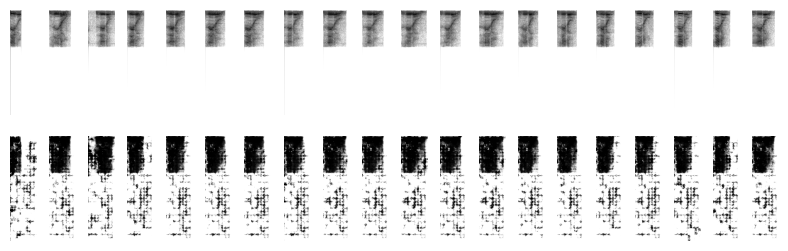

In [10]:
if __name__ == "__main__":
    autoencoder = VAE.load("model_new")
    test_images = x_train[:20]
#     test_images = torch.tensor(test_images, dtype=torch.float32)

    reconstructed_images, _ = autoencoder.reconstruct(test_images)
    plot_reconstructed_images(test_images, reconstructed_images)

In [11]:
# if __name__ == "__main__":
#     autoencoder = VAE.load("model_new")
#     test_images = x_train[:20]
# #     test_images = torch.tensor(test_images, dtype=torch.float32)

#     reconstructed_images, _ = autoencoder.reconstruct(test_images)
#     plot_reconstructed_images(test_images, reconstructed_images)

In [12]:
class SoundGenerator:
    """SoundGenerator is responsible for generating audios from
    spectrograms.
    """

    def __init__(self, vae, hop_length):
        self.vae = vae
        self.hop_length = hop_length
        self._min_max_normaliser = MinMaxNormaliser(0, 1)

    def generate(self, spectrograms, min_max_values):
        generated_spectrograms, latent_representations = \
            self.vae.reconstruct(spectrograms)
        signals = self.convert_spectrograms_to_audio(generated_spectrograms, min_max_values)
        return signals, latent_representations

    def convert_spectrograms_to_audio(self, spectrograms, min_max_values):
        signals = []
        for spectrogram, min_max_value in zip(spectrograms, min_max_values):
            # reshape the log spectrogram
            log_spectrogram = spectrogram[:, :, 0]
            # apply denormalisation
            denorm_log_spec = self._min_max_normaliser.denormalise(
                log_spectrogram, min_max_value["min"], min_max_value["max"])
            # log spectrogram -> spectrogram
            spec = librosa.db_to_amplitude(denorm_log_spec)
            # apply Griffin-Lim
            signal = librosa.istft(spec, hop_length=self.hop_length)
            # append signal to "signals"
            signals.append(signal)
        return signals

In [13]:
HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = "samples/original/"
SAVE_DIR_GENERATED = "samples/generated/"
MIN_MAX_VALUES_PATH = "./MusicGeneration/MinMax_dir/min_max_values.pkl"


def load_fsdd(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)
            x_train.append(spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]
    return x_train, file_paths


def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=2):
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_spectrograms)
    sampled_spectrogrmas = spectrograms[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                           file_paths]
    print(file_paths)
    print(sampled_min_max_values)
    return sampled_spectrogrmas, sampled_min_max_values


def save_signals(signals, save_dir, sample_rate=22050):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

In [14]:
if __name__ == "__main__":
    # initialise sound generator
    vae = VAE.load("model_new")
    sound_generator = SoundGenerator(vae, HOP_LENGTH)

    # load spectrograms + min max values
    with open(MIN_MAX_VALUES_PATH, "rb") as f:
        min_max_values = pickle.load(f)

    specs, file_paths = load_fsdd(SPECTROGRAMS_PATH)
    
#     spectrograms = np.stack(spectrograms)  # Stack into a single NumPy array

#     # Convert NumPy array to PyTorch tensor
#     spectrograms_tensor = torch.tensor(spectrograms, dtype=torch.float32)

    # sample spectrograms + min max values
    sampled_specs, sampled_min_max_values = select_spectrograms(specs,
                                                                file_paths,
                                                                min_max_values,
                                                                5)

    # generate audio for sampled spectrograms
    signals, _ = sound_generator.generate(sampled_specs,
                                          sampled_min_max_values)

    # convert spectrogram samples to audio
    original_signals = sound_generator.convert_spectrograms_to_audio(
        sampled_specs, sampled_min_max_values)

    # save audio signals
    save_signals(signals, SAVE_DIR_GENERATED)
    save_signals(original_signals, SAVE_DIR_ORIGINAL)

['./MusicGeneration/spectogram_save_dir\\0_nicolas_14.wav.npy', './MusicGeneration/spectogram_save_dir\\1_yweweler_19.wav.npy', './MusicGeneration/spectogram_save_dir\\8_nicolas_44.wav.npy', './MusicGeneration/spectogram_save_dir\\7_yweweler_47.wav.npy', './MusicGeneration/spectogram_save_dir\\1_theo_21.wav.npy']
[{'min': -54.83705, 'max': 25.162949}, {'min': -69.1199, 'max': 10.880096}, {'min': -53.53813, 'max': 26.461868}, {'min': -73.21345, 'max': 6.786549}, {'min': -78.130394, 'max': 1.8696084}]


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
